In [1]:
# import libraries
import os
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
from scipy.interpolate import interp1d
import pickle 
import xarray as xr
import matplotlib.colors as colors
import seaborn as sns
import cmocean

# import some home-made functions
import nbimporter

# for mapping
import cartopy.crs as ccrs
# https://cosima-recipes.readthedocs.io/en/latest/tutorials/Making_Maps_with_Cartopy.html
import cartopy.feature as cft
# BIG issue with cartopy: see here https://github.com/SciTools/cartopy/issues/1325 at @jypeter
# I had to download a bunch of stuff myself and put it in ~/.local/share/cartopy/shapefile/.../...
# https://stackoverflow.com/questions/30030328/correct-placement-of-colorbar-relative-to-geo-axes-cartopy
# https://scitools.org.uk/cartopy/docs/v0.15/examples/axes_grid_basic.html
land_110m = cft.NaturalEarthFeature('physical', 'land', '110m', edgecolor='black', facecolor='gray', linewidth=0.5) # continents

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

In [2]:
def compute_flux_total(FseqX, pixel_areas):
    """
    Input : a 2D array with fluxes (can be exported, sequestered, remineralized carbon flux) 
    Output: total amount of exported, sequestered, remineralized carbon flux in GtC/year
    """
    res = np.nansum(np.nansum(FseqX * pixel_areas[:,:]*1e-15, axis = 1)) # in GtC year-1 
    return(res)

In [3]:
# Compute mean total flux
def compute_flux_total_mean(flux, pixel_area):
    tmp = np.zeros(flux.shape[0])
    for i in range(flux.shape[0]):
        tmp[i] = compute_flux_total(flux[i,:,:], pixel_area)
    
    return(np.mean(tmp))

In [4]:
data = open("../data/output_data_for_figures/data_figED3.pkl", "rb")
data = pickle.load(data)

In [5]:
mask = data['mask']
lonT = data['lon']
latT = data['lat']
pixelArea = data['pixelArea']
FseqDOC_H_100m_martin = data['FseqDOC_H_100m_martin']
FseqDOC_H_100m_henson = data['FseqDOC_H_100m_henson']
FseqDOC_H_100m_guidi = data['FseqDOC_H_100m_guidi']
FseqPOC_H_100m_martin = data['FseqPOC_H_100m_martin']
FseqPOC_H_100m_henson = data['FseqPOC_H_100m_henson']
FseqPOC_H_100m_guidi = data['FseqPOC_H_100m_guidi']
FseqMigrD_H_100m_martin = data['FseqMigrD_H_100m_martin']
FseqMigrD_H_100m_henson = data['FseqMigrD_H_100m_henson']
FseqMigrD_H_100m_guidi = data['FseqMigrD_H_100m_guidi']
FseqBCPs_H_100m_martin = data['FseqBCPs_H_100m_martin']
FseqBCPs_H_100m_henson = data['FseqBCPs_H_100m_henson']
FseqBCPs_H_100m_guidi = data['FseqBCPs_H_100m_guidi']
Fsedim = data['Fsedim']
FseqPOC1000m_martin = data['FseqPOC1000m_martin']
FseqPOC1000m_henson = data['FseqPOC1000m_henson']
FseqPOC1000m_guidi = data['FseqPOC1000m_guidi']
FseqPOC2000m_martin = data['FseqPOC2000m_martin']
FseqPOC2000m_henson = data['FseqPOC2000m_henson']
FseqPOC2000m_guidi = data['FseqPOC2000m_guidi']
FexpH = data['FexpH']

/home/fricour/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  result = super().pcolormesh(*args, **kwargs)
/home/fricour/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  result = super().pcolormesh(*args, **kwargs)
/home/fricour/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  result = supe

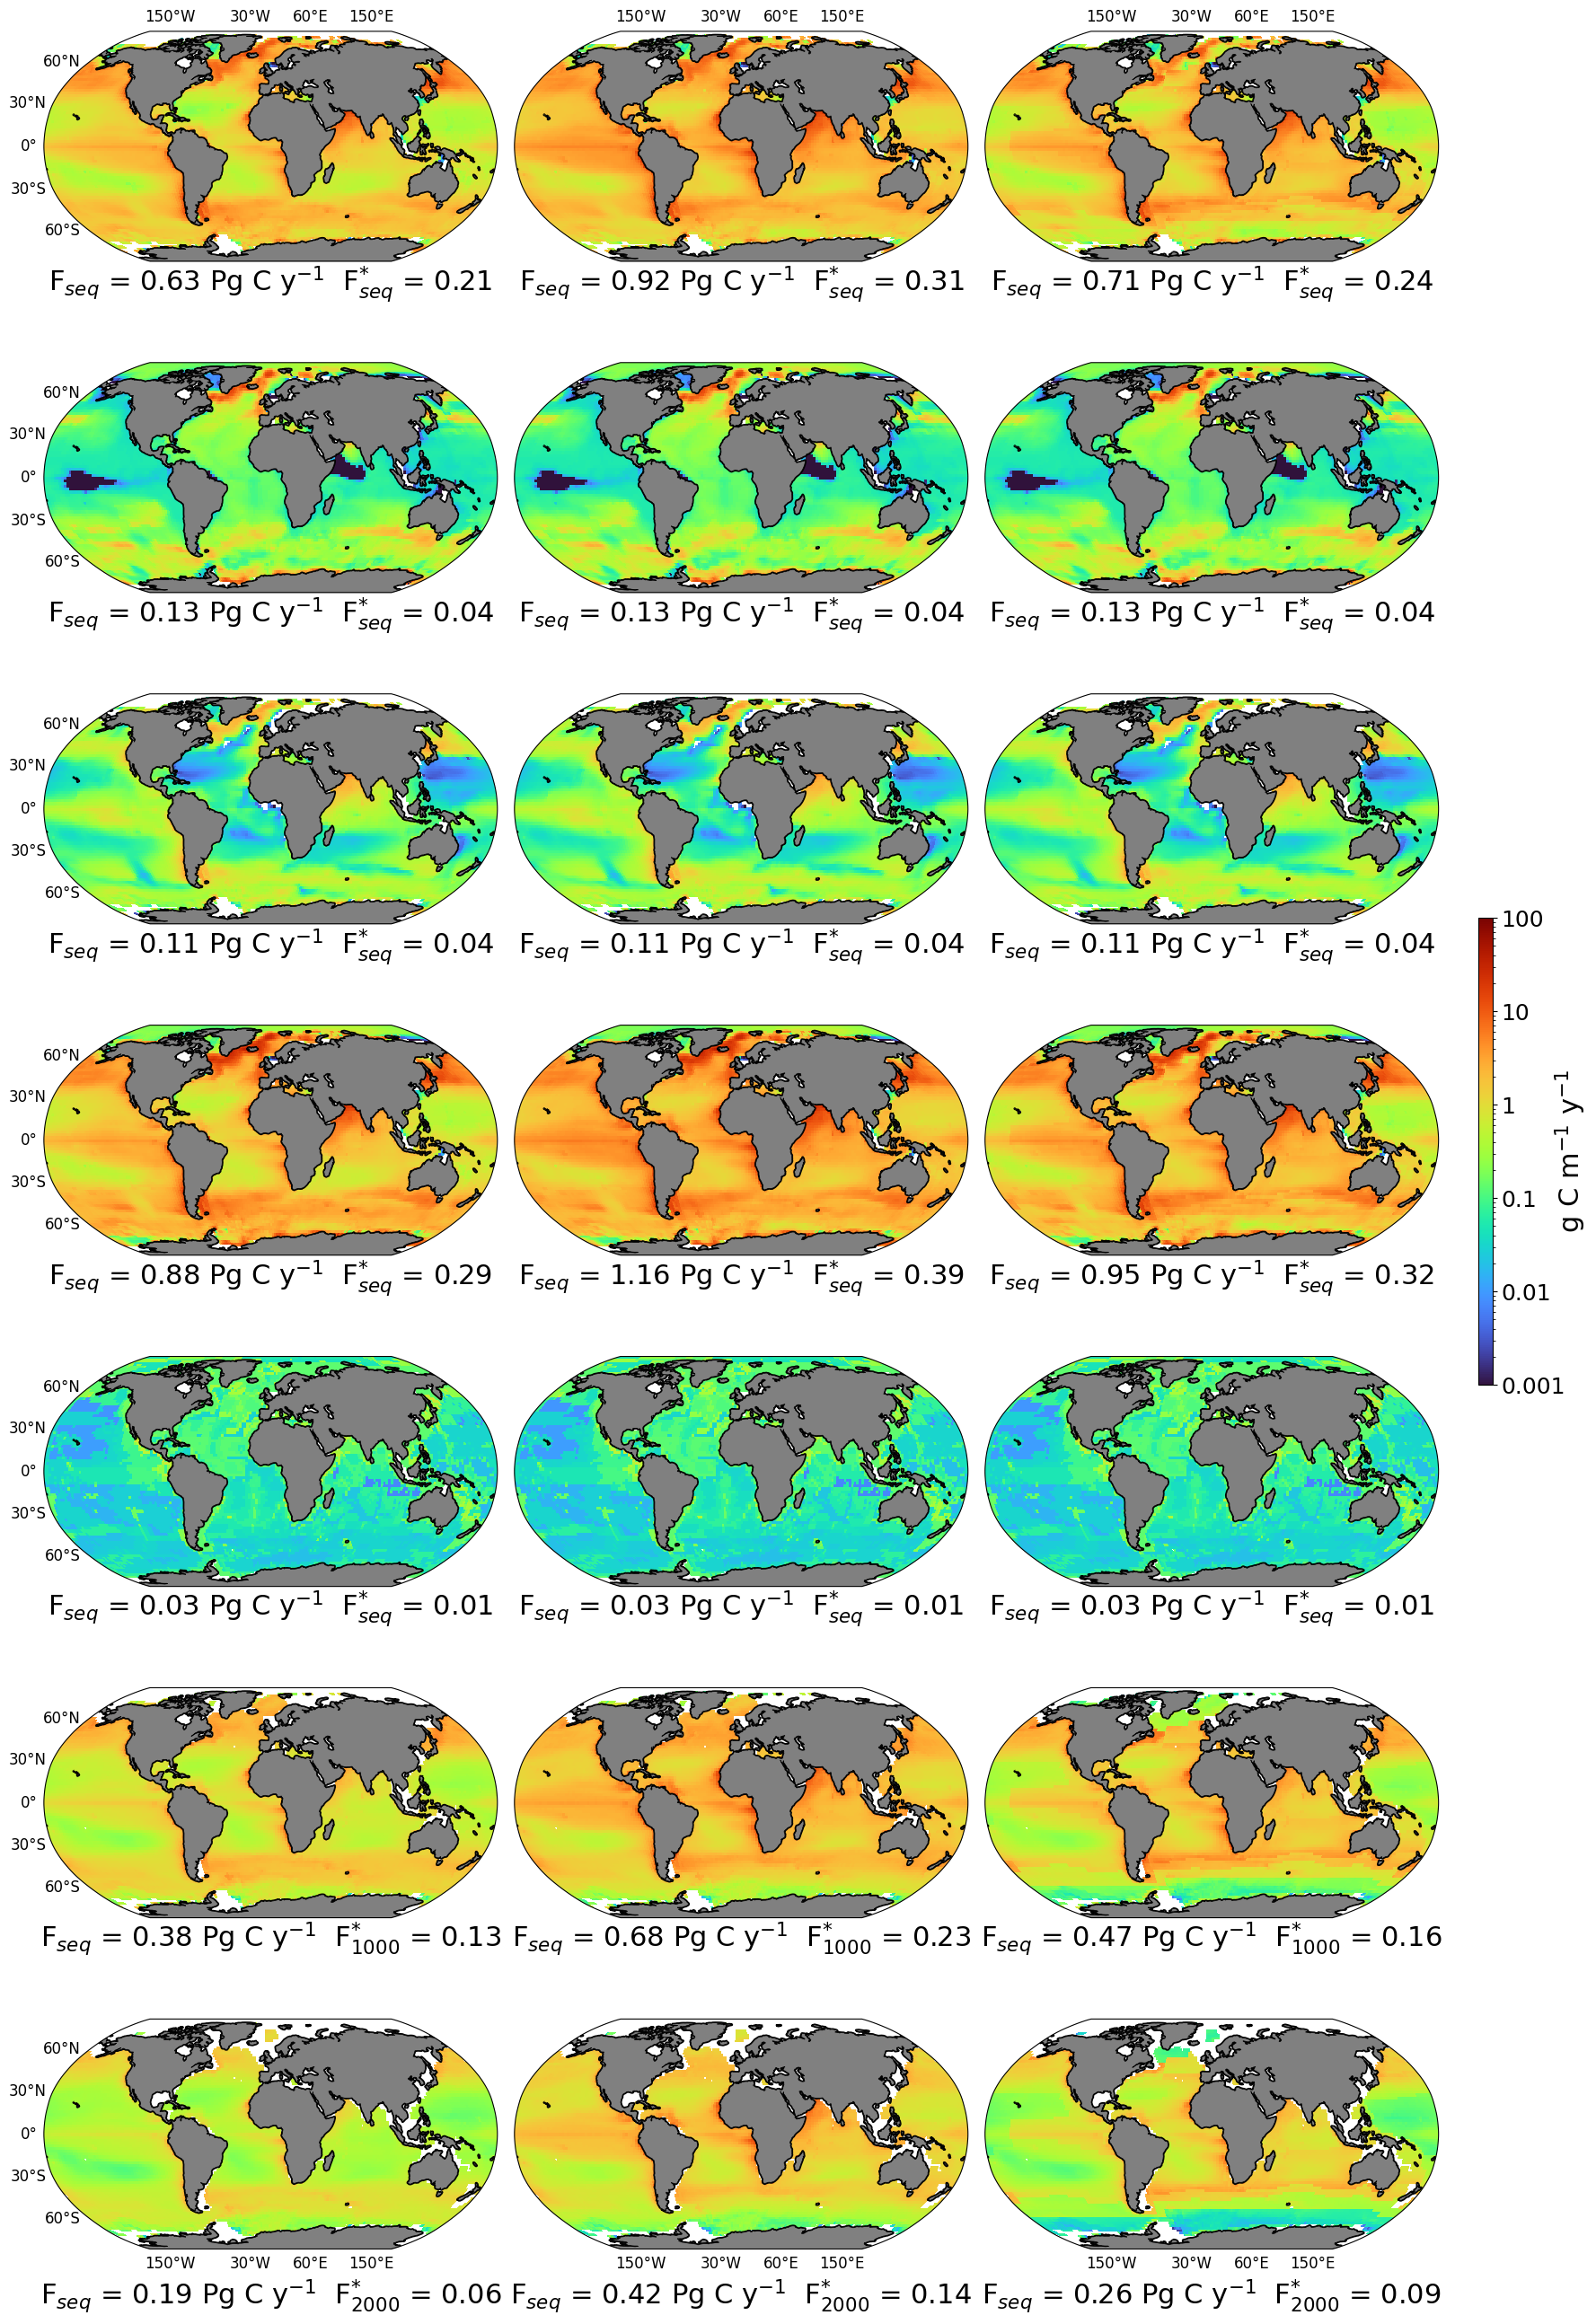

In [6]:
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_multicolumn.html
pal = 'turbo'
#subtitle_color = '#0020bc'
subtitle_color = 'black'
subtitle_fontsize = 22
subtitle_weight = 'normal'
subtitle_y = -0.16

refH = compute_flux_total(FexpH*mask, pixelArea)
FseqDOC_H_100m_C1 = np.where(FseqDOC_H_100m_martin<1e-3, 1e-3, FseqDOC_H_100m_martin) 
FseqDOC_H_100m_C2 = np.where(FseqDOC_H_100m_henson<1e-3, 1e-3, FseqDOC_H_100m_henson) 
FseqDOC_H_100m_C3 = np.where(FseqDOC_H_100m_guidi<1e-3, 1e-3, FseqDOC_H_100m_guidi) 

from matplotlib.gridspec import GridSpec
fig = plt.figure(constrained_layout=True, figsize = (16,26))
gs = GridSpec(7, 3, figure=fig, hspace = 0)

# Gravitational pump

ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson())
ax1.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p1 = ax1.pcolormesh(lonT, latT, FseqPOC_H_100m_martin*mask, vmin = 1e-3, vmax = 1e2, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal, norm=colors.LogNorm()) 
ax1.add_feature(land_110m)
ax1.set_title('F$_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC_H_100m_martin*mask, pixelArea), 2))+' Pg C y$^{-1}$  F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC_H_100m_martin*mask, pixelArea)/refH, 2)),
             y = subtitle_y, fontsize = subtitle_fontsize, color = subtitle_color, fontweight = subtitle_weight)
gl = ax1.gridlines(draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False
gl.top_labels = True
gl.left_labels = True
gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 12} 
gl.ylabel_style = {'size': 12}

ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.Robinson())
ax2.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p2 = ax2.pcolormesh(lonT, latT, FseqPOC_H_100m_henson*mask, vmin = 1e-3, vmax = 1e2, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal, norm=colors.LogNorm()) 
ax2.add_feature(land_110m)
ax2.set_title('F$_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC_H_100m_henson*mask, pixelArea), 2))+' Pg C y$^{-1}$  F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC_H_100m_henson*mask, pixelArea)/refH, 2)),
             y = subtitle_y, fontsize = subtitle_fontsize, color = subtitle_color, fontweight = subtitle_weight)
gl = ax2.gridlines(draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False
gl.top_labels = True
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 12} 
gl.ylabel_style = {'size': 12}

ax3 = fig.add_subplot(gs[0, 2], projection=ccrs.Robinson())
ax3.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p3 = ax3.pcolormesh(lonT, latT, FseqPOC_H_100m_guidi*mask, vmin = 1e-3, vmax = 1e2, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal, norm=colors.LogNorm())
ax3.add_feature(land_110m)
ax3.set_title('F$_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC_H_100m_guidi*mask, pixelArea), 2))+' Pg C y$^{-1}$  F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC_H_100m_guidi*mask, pixelArea)/refH, 2)),
             y = subtitle_y, fontsize = subtitle_fontsize, color = subtitle_color, fontweight = subtitle_weight)
gl = ax3.gridlines(draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False
gl.top_labels = True
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 12} 
gl.ylabel_style = {'size': 12}

# Mixing pump

ax4 = fig.add_subplot(gs[1, 0], projection=ccrs.Robinson())
ax4.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p4 = ax4.pcolormesh(lonT, latT, FseqDOC_H_100m_C1*mask, vmin = 1e-3, vmax = 1e2, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal, norm=colors.LogNorm()) 
ax4.add_feature(land_110m)
ax4.set_title('F$_{seq}$ = '+str(np.round(compute_flux_total(FseqDOC_H_100m_C1*mask, pixelArea), 2))+' Pg C y$^{-1}$  F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqDOC_H_100m_C1*mask, pixelArea)/refH, 2)),
             y = subtitle_y, fontsize = subtitle_fontsize, color = subtitle_color, fontweight = subtitle_weight)
gl = ax4.gridlines(draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 12} 
gl.ylabel_style = {'size': 12}

ax5 = fig.add_subplot(gs[1, 1], projection=ccrs.Robinson())
ax5.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p5 = ax5.pcolormesh(lonT, latT, FseqDOC_H_100m_C2*mask, vmin = 1e-3, vmax = 1e2, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal, norm=colors.LogNorm()) 
ax5.add_feature(land_110m)
ax5.set_title('F$_{seq}$ = '+str(np.round(compute_flux_total(FseqDOC_H_100m_C2*mask, pixelArea), 2))+' Pg C y$^{-1}$  F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqDOC_H_100m_C2*mask, pixelArea)/refH, 2)),
             y = subtitle_y, fontsize = subtitle_fontsize, color = subtitle_color, fontweight = subtitle_weight)
gl = ax5.gridlines(draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 12} 
gl.ylabel_style = {'size': 12}


ax6 = fig.add_subplot(gs[1, 2], projection=ccrs.Robinson())
ax6.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p6 = ax6.pcolormesh(lonT, latT, FseqDOC_H_100m_C3*mask, vmin = 1e-3, vmax = 1e2, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal, norm=colors.LogNorm())
ax6.add_feature(land_110m)
ax6.set_title('F$_{seq}$ = '+str(np.round(compute_flux_total(FseqDOC_H_100m_C3*mask, pixelArea), 2))+' Pg C y$^{-1}$  F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqDOC_H_100m_C3*mask, pixelArea)/refH, 2)),
             y = subtitle_y, fontsize = subtitle_fontsize, color = subtitle_color, fontweight = subtitle_weight)
gl = ax6.gridlines(draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 12} 
gl.ylabel_style = {'size': 12}

# Diel migrant pump

ax7 = fig.add_subplot(gs[2, 0], projection=ccrs.Robinson())
ax7.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p7 = ax7.pcolormesh(lonT, latT, FseqMigrD_H_100m_martin*mask, vmin = 1e-3, vmax = 1e2, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal, norm=colors.LogNorm()) 
ax7.add_feature(land_110m)
ax7.set_title('F$_{seq}$ = '+str(np.round(compute_flux_total(FseqMigrD_H_100m_martin*mask, pixelArea), 2))+' Pg C y$^{-1}$  F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqMigrD_H_100m_martin*mask, pixelArea)/refH, 2)),
             y = subtitle_y, fontsize = subtitle_fontsize, color = subtitle_color, fontweight = subtitle_weight)
gl = ax7.gridlines(draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 12} 
gl.ylabel_style = {'size': 12}

ax8 = fig.add_subplot(gs[2, 1], projection=ccrs.Robinson())
ax8.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p8 = ax8.pcolormesh(lonT, latT, FseqMigrD_H_100m_henson*mask, vmin = 1e-3, vmax = 1e2, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal, norm=colors.LogNorm())
ax8.add_feature(land_110m)
ax8.set_title('F$_{seq}$ = '+str(np.round(compute_flux_total(FseqMigrD_H_100m_henson*mask, pixelArea), 2))+' Pg C y$^{-1}$  F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqMigrD_H_100m_henson*mask, pixelArea)/refH, 2)),
             y = subtitle_y, fontsize = subtitle_fontsize, color = subtitle_color, fontweight = subtitle_weight)
gl = ax8.gridlines(draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 12} 
gl.ylabel_style = {'size': 12}

ax9 = fig.add_subplot(gs[2, 2], projection=ccrs.Robinson())
ax9.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p9 = ax9.pcolormesh(lonT, latT, FseqMigrD_H_100m_guidi*mask, vmin = 1e-3, vmax = 1e2, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal, norm=colors.LogNorm()) 
ax9.add_feature(land_110m)
ax9.set_title('F$_{seq}$ = '+str(np.round(compute_flux_total(FseqMigrD_H_100m_guidi*mask, pixelArea), 2))+' Pg C y$^{-1}$  F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqMigrD_H_100m_guidi*mask, pixelArea)/refH, 2)),
             y = subtitle_y, fontsize = subtitle_fontsize, color = subtitle_color, fontweight = subtitle_weight)
gl = ax9.gridlines(draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 12} 
gl.ylabel_style = {'size': 12}

# FseqBCPs

ax13 = fig.add_subplot(gs[3, 0], projection=ccrs.Robinson())
ax13.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p13 = ax13.pcolormesh(lonT, latT, FseqBCPs_H_100m_martin*mask, vmin = 1e-3, vmax = 1e2, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal, norm=colors.LogNorm()) 
ax13.add_feature(land_110m)
ax13.set_title('F$_{seq}$ = '+str(np.round(compute_flux_total(FseqBCPs_H_100m_martin*mask, pixelArea), 2))+' Pg C y$^{-1}$  F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqBCPs_H_100m_martin*mask, pixelArea)/refH, 2)),
             y = subtitle_y, fontsize = subtitle_fontsize, color = subtitle_color, fontweight = subtitle_weight)
gl = ax13.gridlines(draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 12} 
gl.ylabel_style = {'size': 12}

ax14 = fig.add_subplot(gs[3, 1], projection=ccrs.Robinson())
ax14.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p14 = ax14.pcolormesh(lonT, latT, FseqBCPs_H_100m_henson*mask, vmin = 1e-3, vmax = 1e2, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal, norm=colors.LogNorm())
ax14.add_feature(land_110m)
ax14.set_title('F$_{seq}$ = '+str(np.round(compute_flux_total(FseqBCPs_H_100m_henson*mask, pixelArea), 2))+' Pg C y$^{-1}$  F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqBCPs_H_100m_henson*mask, pixelArea)/refH, 2)),
             y = subtitle_y, fontsize = subtitle_fontsize, color = subtitle_color, fontweight = subtitle_weight)
gl = ax14.gridlines(draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 12} 
gl.ylabel_style = {'size': 12}

ax15 = fig.add_subplot(gs[3, 2], projection=ccrs.Robinson())
ax15.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p15 = ax15.pcolormesh(lonT, latT, FseqBCPs_H_100m_guidi*mask, vmin = 1e-3, vmax = 1e2, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal, norm=colors.LogNorm()) 
ax15.add_feature(land_110m)
ax15.set_title('F$_{seq}$ = '+str(np.round(compute_flux_total(FseqBCPs_H_100m_guidi*mask, pixelArea), 2))+' Pg C y$^{-1}$  F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqBCPs_H_100m_guidi*mask, pixelArea)/refH, 2)),
             y = subtitle_y, fontsize = subtitle_fontsize, color = subtitle_color, fontweight = subtitle_weight)
gl = ax15.gridlines(draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 12} 
gl.ylabel_style = {'size': 12}

# Fseqsedim

ax16 = fig.add_subplot(gs[4, 0], projection=ccrs.Robinson())
ax16.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p16 = ax16.pcolormesh(lonT, latT, Fsedim*mask, vmin = 1e-3, vmax = 1e2, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal, norm=colors.LogNorm()) 
ax16.add_feature(land_110m)
ax16.set_title('F$_{seq}$ = '+str(np.round(compute_flux_total(Fsedim*mask, pixelArea), 2))+' Pg C y$^{-1}$  F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(Fsedim*mask, pixelArea)/refH, 2)),
             y = subtitle_y, fontsize = subtitle_fontsize, color = subtitle_color, fontweight = subtitle_weight)
gl = ax16.gridlines(draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 12} 
gl.ylabel_style = {'size': 12}

ax17 = fig.add_subplot(gs[4, 1], projection=ccrs.Robinson())
ax17.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p17 = ax17.pcolormesh(lonT, latT, Fsedim*mask, vmin = 1e-3, vmax = 1e2, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal, norm=colors.LogNorm())
ax17.add_feature(land_110m)
ax17.set_title('F$_{seq}$ = '+str(np.round(compute_flux_total(Fsedim*mask, pixelArea), 2))+' Pg C y$^{-1}$  F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(Fsedim*mask, pixelArea)/refH, 2)),
             y = subtitle_y, fontsize = subtitle_fontsize, color = subtitle_color, fontweight = subtitle_weight)
gl = ax17.gridlines(draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 12} 
gl.ylabel_style = {'size': 12}

ax18 = fig.add_subplot(gs[4, 2], projection=ccrs.Robinson())
ax18.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p18 = ax18.pcolormesh(lonT, latT, Fsedim*mask, vmin = 1e-3, vmax = 1e2, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal, norm=colors.LogNorm()) 
ax18.add_feature(land_110m)
ax18.set_title('F$_{seq}$ = '+str(np.round(compute_flux_total(Fsedim*mask, pixelArea), 2))+' Pg C y$^{-1}$  F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(Fsedim*mask, pixelArea)/refH, 2)),
             y = subtitle_y, fontsize = subtitle_fontsize, color = subtitle_color, fontweight = subtitle_weight)
gl = ax18.gridlines(draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 12} 
gl.ylabel_style = {'size': 12}

# Fseq at 1000 m

ax19 = fig.add_subplot(gs[5, 0], projection=ccrs.Robinson())
ax19.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p19 = ax19.pcolormesh(lonT, latT, FseqPOC1000m_martin*mask, vmin = 1e-3, vmax = 1e2, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal, norm=colors.LogNorm()) 
ax19.add_feature(land_110m)
ax19.set_title('F$_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC1000m_martin*mask, pixelArea), 2))+' Pg C y$^{-1}$  F$^{*}_{1000}$ = '+str(np.round(compute_flux_total(FseqPOC1000m_martin*mask, pixelArea)/refH, 2)),
             y = subtitle_y, fontsize = subtitle_fontsize, color = subtitle_color, fontweight = subtitle_weight)
gl = ax19.gridlines(draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 12} 
gl.ylabel_style = {'size': 12}

ax20 = fig.add_subplot(gs[5, 1], projection=ccrs.Robinson())
ax20.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p20 = ax20.pcolormesh(lonT, latT, FseqPOC1000m_henson*mask, vmin = 1e-3, vmax = 1e2, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal, norm=colors.LogNorm())
ax20.add_feature(land_110m)
ax20.set_title('F$_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC1000m_henson*mask, pixelArea), 2))+' Pg C y$^{-1}$  F$^{*}_{1000}$ = '+str(np.round(compute_flux_total(FseqPOC1000m_henson*mask, pixelArea)/refH, 2)),
             y = subtitle_y, fontsize = subtitle_fontsize, color = subtitle_color, fontweight = subtitle_weight)
gl = ax20.gridlines(draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 12} 
gl.ylabel_style = {'size': 12}

ax21 = fig.add_subplot(gs[5, 2], projection=ccrs.Robinson())
ax21.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p21 = ax21.pcolormesh(lonT, latT, FseqPOC1000m_guidi*mask, vmin = 1e-3, vmax = 1e2, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal, norm=colors.LogNorm()) 
ax21.add_feature(land_110m)
ax21.set_title('F$_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC1000m_guidi*mask, pixelArea), 2))+' Pg C y$^{-1}$  F$^{*}_{1000}$ = '+str(np.round(compute_flux_total(FseqPOC1000m_guidi*mask, pixelArea)/refH, 2)),
             y = subtitle_y, fontsize = subtitle_fontsize, color = subtitle_color, fontweight = subtitle_weight)
gl = ax21.gridlines(draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 12} 
gl.ylabel_style = {'size': 12}

# Fseq at 2000 m

ax22 = fig.add_subplot(gs[6, 0], projection=ccrs.Robinson())
ax22.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p22 = ax22.pcolormesh(lonT, latT, FseqPOC2000m_martin*mask, vmin = 1e-3, vmax = 1e2, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal, norm=colors.LogNorm()) 
ax22.add_feature(land_110m)
ax22.set_title('F$_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC2000m_martin*mask, pixelArea), 2))+' Pg C y$^{-1}$  F$^{*}_{2000}$ = '+str(np.round(compute_flux_total(FseqPOC2000m_martin*mask, pixelArea)/refH, 2)),
             y = subtitle_y, fontsize = subtitle_fontsize, color = subtitle_color, fontweight = subtitle_weight, pad = -15)
gl = ax22.gridlines(draw_labels=True)
gl.bottom_labels = True
gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 12} 
gl.ylabel_style = {'size': 12}

ax23 = fig.add_subplot(gs[6, 1], projection=ccrs.Robinson())
ax23.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p23 = ax23.pcolormesh(lonT, latT, FseqPOC2000m_henson*mask, vmin = 1e-3, vmax = 1e2, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal, norm=colors.LogNorm())
ax23.add_feature(land_110m)
ax23.set_title('F$_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC2000m_henson*mask, pixelArea), 2))+' Pg C y$^{-1}$  F$^{*}_{2000}$ = '+str(np.round(compute_flux_total(FseqPOC2000m_henson*mask, pixelArea)/refH, 2)),
             y = subtitle_y, fontsize = subtitle_fontsize, color = subtitle_color, fontweight = subtitle_weight, pad = -15)
gl = ax23.gridlines(draw_labels=True)
gl.bottom_labels = True
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 12} 
gl.ylabel_style = {'size': 12}


ax24 = fig.add_subplot(gs[6, 2], projection=ccrs.Robinson())
ax24.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p24 = ax24.pcolormesh(lonT, latT, FseqPOC2000m_guidi*mask, vmin = 1e-3, vmax = 1e2, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal, norm=colors.LogNorm()) 
ax24.add_feature(land_110m)
ax24.set_title('F$_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC2000m_guidi*mask, pixelArea), 2))+' Pg C y$^{-1}$  F$^{*}_{2000}$ = '+str(np.round(compute_flux_total(FseqPOC2000m_guidi*mask, pixelArea)/refH, 2)),
             y = subtitle_y, fontsize = subtitle_fontsize, color = subtitle_color, fontweight = subtitle_weight, pad = -15)
gl = ax24.gridlines(draw_labels=True)
gl.bottom_labels = True
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 12} 
gl.ylabel_style = {'size': 12}

#cbar_ax = fig.add_axes([.2, .005, .6, .005]) # for horizontal colorbar
cbar_ax = fig.add_axes([1.025, .4, .01, .2]) # move on x, move on y, length, width
col = fig.colorbar(p4, cax=cbar_ax, orientation = 'vertical', pad = -0.5)
#cbar = plt.colorbar(p, orientation='horizontal', aspect = 100, pad = 0.05)
col.set_label('g C m$^{-1}$ y$^{-1}$', fontsize = 22, labelpad = -10)
col.set_ticks([1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2])
col.set_ticklabels([0.001, 0.01, 0.1, 1, 10, 100])
col.ax.tick_params(labelsize=18)

plt.savefig('FigED3.jpg', bbox_inches = "tight", dpi=300)
plt.show()